## Trading Simulator 
Let's do this!

### Iteration 01 | Start (2017, 1, 1) | End (2019, 1, 1)

A common trading rule says: buy when the 30-day moving average goes above the 180-day moving average <b><i>(the BUY rule)</i></b>, and sell when it goes below <b><i>(the SELL rule)</i></b>. 

Let's assume we buy 1 share at the closing price the very day the BUY rule triggers, and sell that 1 share the SELL triggers. (Now this is a bit tricky as we need that day's closing price to compute the average, but let's gloss over that). At the end, we want the overall return.

To achieve the above:
1. Step 01: Compute the daily return ratio i.e., <b>the ratio of today's closing price to yesterday's closing price</b>. 
2. Step 02: Create a mask of the days when we <b>hold the share</b>, i.e., the BUY has triggered, but the SELL rule has not. 
3. Step 03: Compute the cumulative return ratio over the days of the mask. This is the <b>product of the return ratios</b> on the days I hold the share. 
    
<b>Step 01: Daily Returns</b>

In [42]:
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

start_date = datetime(2017, 1, 1) #Jan1,2016
end_date = datetime(2019, 1, 1)   #Jan1,2018

# Get Tesla stock for these dates
df = web.DataReader('TSLA', 'stooq', start_date, end_date)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

df[:5]

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,14.3240,14.6887,14.0640,14.4660,82936545
2017-01-04,14.3167,15.2000,14.2873,15.1327,166881135
2017-01-05,15.0947,15.1653,14.7967,15.1167,87832155
2017-01-06,15.1287,15.3540,15.0300,15.2673,81965850
2017-01-09,15.2647,15.4613,15.2000,15.4187,58693575


In [43]:
closes = df['Close']
daily_return_ratio = closes / closes.shift(1)
daily_return_ratio[:5]

Date
2017-01-03         NaN
2017-01-04    1.046087
2017-01-05    0.998943
2017-01-06    1.009962
2017-01-09    1.009917
Name: Close, dtype: float64

<b>Step 02: Mask of Days when we hold share</b>

1. Compute 30-day and 180-day moving averages
2. Find the days when the 30-day average is greater than the 180-day average
3. On which days to hold the share 

Consider the following example: \
The 30-day average is greater than the 180-day average on 5th Jan, 6th Jan, ..., 11th Jan. It falls below the 180-day average on 12th Jan. So, we buy the share at close of 5th Jan, sell at the close of 12th Jan. Hence we held the share (and got its returns) for 6th Jan, 7th Jan, ..., 12th Jan. 

Basically we hold the share when it is on a high, that maximizes our returns. 

Thus, the days we hold the share is shifted one day from the period the 30-day moving average is higher. 

Re-iterating the step 02 as:

1. Compute 30-day and 180-day moving averages
2. Find the days when the 30-day average is greater than the 180-day average
3. The days we hold the share is shifted one day from the periods found in Step 2. 

<b>Step 2.1: Moving Averages</b>

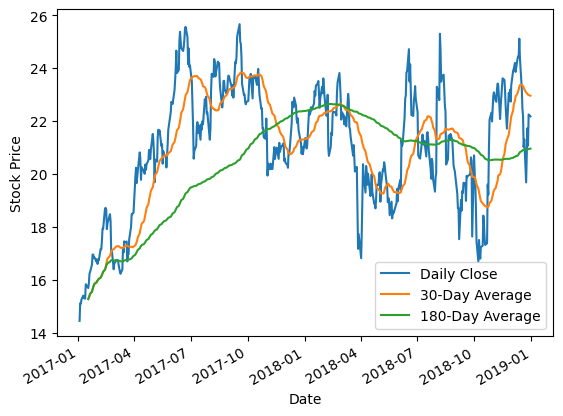

In [44]:
mavg_30 = closes.rolling(window = 30, min_periods = 10).mean()
mavg_180 = closes.rolling(window = 180, min_periods = 10).mean()

closes.plot(label = 'Daily Close')
mavg_30.plot(label = '30-Day Average')
mavg_180.plot(label = '180-Day Average')
plt.ylabel('Stock Price')
plt.legend(loc = 'best')

<b>Step 2.2: Find the days the 30-days average is greater</b>

In [45]:
mavg_30_is_greater = (mavg_30 > mavg_180)
mavg_30_is_greater['2017-02-08':'2017-02-22']

Date
2017-02-08    False
2017-02-09    False
2017-02-10    False
2017-02-13    False
2017-02-14    False
2017-02-15     True
2017-02-16     True
2017-02-17     True
2017-02-21     True
2017-02-22     True
Name: Close, dtype: bool

<b>Step 2.3: Hold on the days the 30-day moving average is greater, but shifted by 1</b>

In [46]:
hold_days = mavg_30_is_greater.shift(1)
hold_days['2017-02-08':'2017-02-22']

Date
2017-02-08    False
2017-02-09    False
2017-02-10    False
2017-02-13    False
2017-02-14    False
2017-02-15    False
2017-02-16     True
2017-02-17     True
2017-02-21     True
2017-02-22     True
Name: Close, dtype: object

So far, we have computed daily returns, and we have computed the days on which we hold the share. Now, we need to compute the returns just on the days we hold the share and take the product of these daily returns.

In [47]:
hold_days[0:3] 

Date
2017-01-03      NaN
2017-01-04    False
2017-01-05    False
Name: Close, dtype: object

But we have a small problem here, the first date is NaN, because of the shift(). We cannot use hold_days as a mask for daily_return_ratio because the mask must contain only False or True. So let's fix it. 

In [48]:
hold_days = hold_days.fillna(False)
hold_days[0:3]

Date
2017-01-03    False
2017-01-04    False
2017-01-05    False
Name: Close, dtype: bool

Let's see the period when we hold the share: 

[Text(0, 0.0, ''),
 Text(0, 0.5, ''),
 Text(0, 1.0, ''),
 Text(0, 1.5, ''),
 Text(0, 2.0, '')]

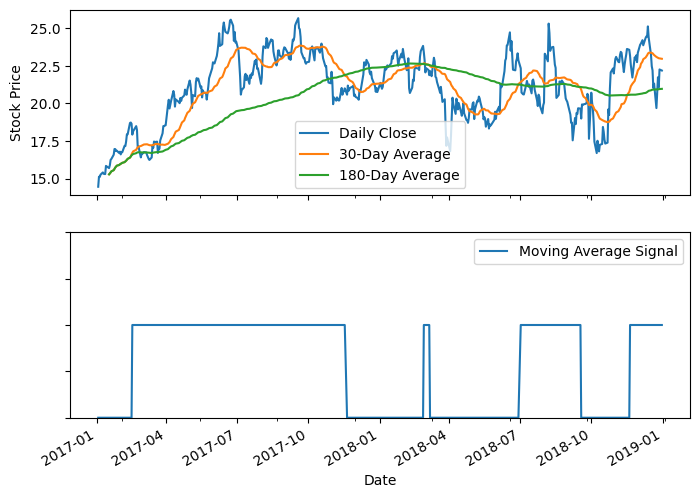

In [49]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (8, 6))
closes.plot(ax = ax1, label = 'Daily Close')
mavg_30.plot(ax = ax1, label = '30-Day Average')
mavg_180.plot(ax = ax1, label = '180-Day Average')
ax1.legend(loc = 'best')
ax1.set_ylabel('Stock Price')

hold_days.astype(int).plot(ax = ax2, ylim = [0, 2], label = 'Moving Average Signal')
ax2.legend(loc = 'best')
ax2.yaxis.set_ticklabels([])

<b>Finally: Compute cumulative return</b>\
First, we find the returns on the days we hold the share 

In [50]:
s = daily_return_ratio[hold_days]
s[:5]

Date
2017-02-16    0.961358
2017-02-17    1.012197
2017-02-21    1.018955
2017-02-22    0.986011
2017-02-23    0.935944
Name: Close, dtype: float64

Overall return is the product of the returns on each day we held a share

In [51]:
print('Overall return ratio =', s.prod())

Overall return ratio = 0.8371915216683729


To access whether this is good or not, we can compare it to a buy-and-hold strategy, where we buy on the first day and sell on the last day. 

In [52]:
print('Return of buy-and-hold =', daily_return_ratio.prod())

Return of buy-and-hold = 1.5337135351859534


Let's see how the cumulative return of the moving average strategy compares to buy-and-hold. 

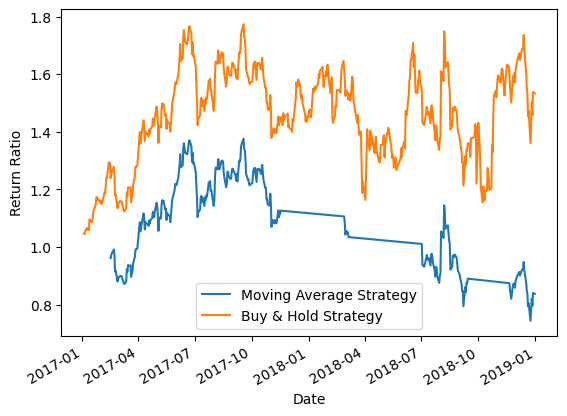

In [53]:
s.cumprod().plot(label = 'Moving Average Strategy')
daily_return_ratio.cumprod().plot(label = 'Buy & Hold Strategy')
plt.ylabel('Return Ratio')
plt.legend(loc = 'best')

We can notice that by the time the moving average strategy sells, the downturn has already hit hard. 
Also, buy the time it buys, prices have already gone up quite a bit. 

### Iteration 02 | Start (2021, 1, 1) | End (2022, 1, 1)

In [54]:
start_date = datetime(2021, 1, 1) 
end_date = datetime(2022, 1, 1)   

df = web.DataReader('TSLA', 'stooq', start_date, end_date)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

df[:5]

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,239.820,248.163,239.063,243.257,145914567
2021-01-05,241.220,246.947,239.733,245.037,96735495
2021-01-06,252.830,258.000,249.700,251.993,134099895
2021-01-07,259.210,272.330,258.400,272.013,154496844
2021-01-08,285.333,294.830,279.463,293.340,225166584


In [55]:
closes = df['Close']
daily_return_ratio = closes / closes.shift(1)

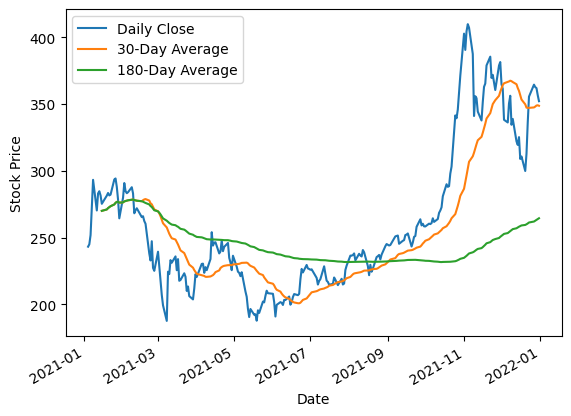

In [56]:
mavg_30 = closes.rolling(window = 30, min_periods = 10).mean()
mavg_180 = closes.rolling(window = 180, min_periods = 10).mean()

closes.plot(label = 'Daily Close')
mavg_30.plot(label = '30-Day Average')
mavg_180.plot(label = '180-Day Average')
plt.ylabel('Stock Price')
plt.legend(loc = 'best')

In [57]:
mavg_30_is_greater = (mavg_30 > mavg_180)
hold_days = mavg_30_is_greater.shift(1)
hold_days = hold_days.fillna(False)

[Text(0, 0.0, ''),
 Text(0, 0.5, ''),
 Text(0, 1.0, ''),
 Text(0, 1.5, ''),
 Text(0, 2.0, '')]

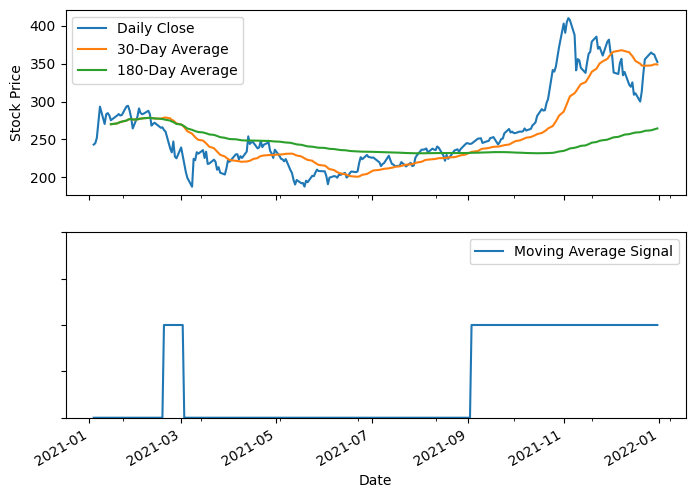

In [58]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (8, 6))
closes.plot(ax = ax1, label = 'Daily Close')
mavg_30.plot(ax = ax1, label = '30-Day Average')
mavg_180.plot(ax = ax1, label = '180-Day Average')
ax1.legend(loc = 'best')
ax1.set_ylabel('Stock Price')

hold_days.astype(int).plot(ax = ax2, ylim = [0, 2], label = 'Moving Average Signal')
ax2.legend(loc = 'best')
ax2.yaxis.set_ticklabels([])

In [59]:
s = daily_return_ratio[hold_days]
print('Overall return ratio =', s.prod())

Overall return ratio = 1.240965224955359


In [60]:
print('Return of buy-and-hold =', daily_return_ratio.prod())

Return of buy-and-hold = 1.4480981020073438


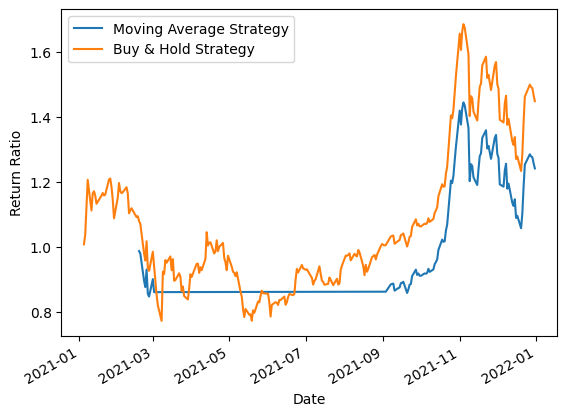

In [61]:
s.cumprod().plot(label = 'Moving Average Strategy')
daily_return_ratio.cumprod().plot(label = 'Buy & Hold Strategy')
plt.ylabel('Return Ratio')
plt.legend(loc = 'best')

### Iteration 03 | Start (2017, 1, 1) | End (2022, 1, 1)

In [63]:
start_date = datetime(2017, 1, 1) 
end_date = datetime(2022, 1, 1)   

df = web.DataReader('TSLA', 'stooq', start_date, end_date)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

df[:5]

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,14.3240,14.6887,14.0640,14.4660,82936545
2017-01-04,14.3167,15.2000,14.2873,15.1327,166881135
2017-01-05,15.0947,15.1653,14.7967,15.1167,87832155
2017-01-06,15.1287,15.3540,15.0300,15.2673,81965850
2017-01-09,15.2647,15.4613,15.2000,15.4187,58693575


In [64]:
closes = df['Close']
daily_return_ratio = closes / closes.shift(1)

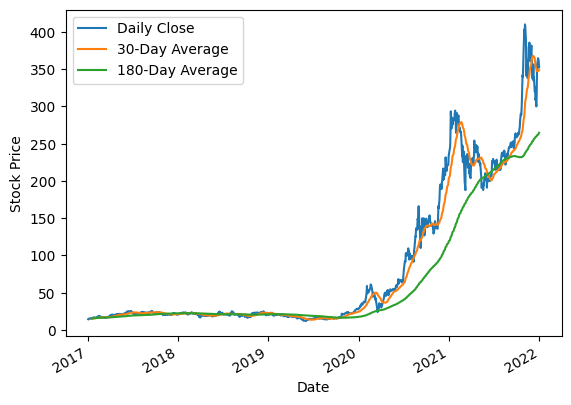

In [65]:
mavg_30 = closes.rolling(window = 30, min_periods = 10).mean()
mavg_180 = closes.rolling(window = 180, min_periods = 10).mean()

closes.plot(label = 'Daily Close')
mavg_30.plot(label = '30-Day Average')
mavg_180.plot(label = '180-Day Average')
plt.ylabel('Stock Price')
plt.legend(loc = 'best')

In [66]:
mavg_30_is_greater = (mavg_30 > mavg_180)
hold_days = mavg_30_is_greater.shift(1)
hold_days = hold_days.fillna(False)

[Text(0, 0.0, ''),
 Text(0, 0.5, ''),
 Text(0, 1.0, ''),
 Text(0, 1.5, ''),
 Text(0, 2.0, '')]

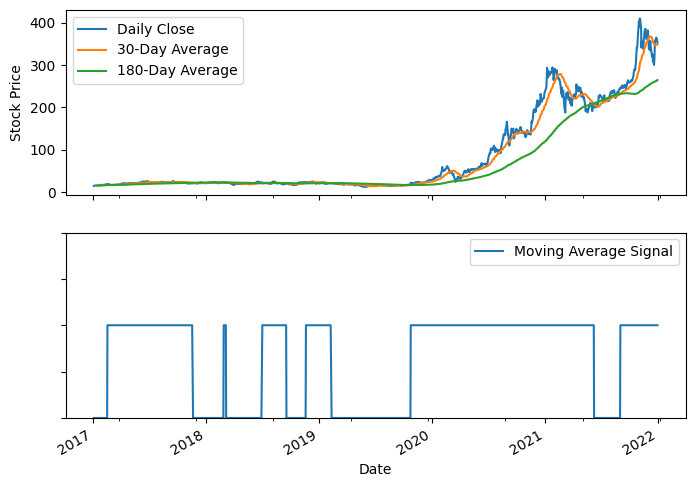

In [67]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (8, 6))
closes.plot(ax = ax1, label = 'Daily Close')
mavg_30.plot(ax = ax1, label = '30-Day Average')
mavg_180.plot(ax = ax1, label = '180-Day Average')
ax1.legend(loc = 'best')
ax1.set_ylabel('Stock Price')

hold_days.astype(int).plot(ax = ax2, ylim = [0, 2], label = 'Moving Average Signal')
ax2.legend(loc = 'best')
ax2.yaxis.set_ticklabels([])

In [68]:
s = daily_return_ratio[hold_days]
print('Overall return ratio =', s.prod())

Overall return ratio = 11.152391420779512


In [69]:
print('Return of buy-and-hold =', daily_return_ratio.prod())

Return of buy-and-hold = 24.350891746163526


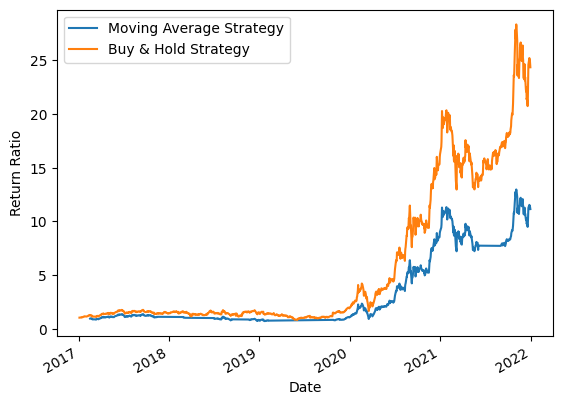

In [70]:
s.cumprod().plot(label = 'Moving Average Strategy')
daily_return_ratio.cumprod().plot(label = 'Buy & Hold Strategy')
plt.ylabel('Return Ratio')
plt.legend(loc = 'best')